# USE Sentence Embeddings with NLU        
The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

## Sources :
- https://arxiv.org/abs/1803.11175
- https://tfhub.dev/google/universal-sentence-encoder/2

## Paper Abstract : 

We present models for encoding sentences into embedding vectors that specifically target transfer learning to other NLP tasks. The models are efficient and result in accurate performance on diverse transfer tasks. Two variants of the encoding models allow for trade-offs between accuracy and compute resources. For both variants, we investigate and report the relationship between model complexity, resource consumption, the availability of transfer task training data, and task performance. Comparisons are made with baselines that use word level transfer learning via pretrained word embeddings as well as baselines do not use any transfer learning. We find that transfer learning using sentence embeddings tends to outperform word level transfer. With transfer learning via sentence embeddings, we observe surprisingly good performance with minimal amounts of supervised training data for a transfer task. We obtain encouraging results on Word Embedding Association Tests (WEAT) targeted at detecting model bias. Our pre-trained sentence encoding models are made freely available for download and on TF Hub.



# 1. Install Java and NLU

In [ ]:

import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! pip install nlu  > /dev/null    

## 2. Load Model and embed sample string with USE

In [ ]:
import nlu
pipe = nlu.load('use')
pipe.predict('He was suprised by the diversity of NLU')

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


,sentence,use_embeddings
origin_index,,
0,He was suprised by the diversity of NLU,"[0.08481953293085098, -0.06140690669417381, 0...."


# 3. Download Sample dataset

In [ ]:
import pandas as pd
# Download the dataset 
! wget -N https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv -P /tmp
# Load dataset to Pandas
df = pd.read_csv('/tmp/train-balanced-sarcasm.csv')
df

--2020-10-07 01:18:59--  https://s3.amazonaws.com/auxdata.johnsnowlabs.com/public/resources/en/sarcasm/train-balanced-sarcasm.csv
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.81.27
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.81.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255268960 (243M) [text/csv]
Saving to: ‘/tmp/train-balanced-sarcasm.csv’

train-balanced-sarc 100%[===================>] 243.44M  34.5MB/s    in 6.1s    

2020-10-07 01:19:06 (40.2 MB/s) - ‘/tmp/train-balanced-sarcasm.csv’ saved [255268960/255268960]



,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


# 4.1 Visualize Embeddings with T-SNE




Lets add Sentiment Part Of Speech to our pipeline because its so easy and so we can hue our T-SNE plots by POS and Sentiment       
We predict the first 5k comments 

In [ ]:
pipe = nlu.load('pos sentiment use emotion') # emotion
df['text'] = df['comment']

# We must set output level to sentence since NLU will infer a different output level for this pipeline composition
predictions = pipe.predict(df[['text','label']].iloc[0:500], output_level='sentence')
predictions

pos_anc download started this may take some time.
Approximate size to download 4.3 MB
[OK!]
analyze_sentiment download started this may take some time.
Approx size to download 4.9 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]


,document_assembler@sentiment,text,sentiment,sentence,category,sentiment_confidence,category_confidence,checked,sentence_embeddings,pos,label,sentence_detector@sentiment
origin_index,,,,,,,,,,,,
0,[NC and NH.],NC and NH.,negative,NC and NH.,surprise,0.522900,0.972704,"[NC, and, NH, .]","[-0.06570463627576828, -0.03522053360939026, -...","[NNP, CC, NNP, .]",0,[NC and NH.]
1,[You do know west teams play against west team...,You do know west teams play against west teams...,negative,You do know west teams play against west teams...,fear,0.473300,0.999838,"[You, do, know, west, teams, play, against, we...","[-0.0254225991666317, 0.05448468029499054, -0....","[PRP, VBP, VB, NN, NNS, VBP, IN, NN, NNS, JJR,...",0,[You do know west teams play against west team...
2,"[They were underdogs earlier today, but since ...","They were underdogs earlier today, but since G...",negative,"They were underdogs earlier today, but since G...",surprise,0.511800,0.988985,"[They, were, underdogs, earlier, today, ,, but...","[-0.0035701016895473003, -0.030124755576252937...","[PRP, VBD, NNS, RBR, NN, ,, CC, IN, NNP, NN, D...",0,"[They were underdogs earlier today, but since ..."
3,"[This meme isn't funny none of the ""new york n...","This meme isn't funny none of the ""new york ni...",negative,"This meme isn't funny none of the ""new york ni...",sadness,0.515500,0.998739,"[This, meme, isn't, funny, none, of, the, "", n...","[0.06464719027280807, -0.023972542956471443, -...","[DT, NN, NN, JJ, NN, IN, DT, '', JJ, NNP, NN, ...",0,"[This meme isn't funny none of the ""new york n..."
4,[I could use one of those tools.],I could use one of those tools.,negative,I could use one of those tools.,sadness,0.474500,0.996461,"[I, could, use, one, of, those, tools, .]","[0.028676817193627357, 0.0199710875749588, 0.0...","[PRP, MD, VB, CD, IN, DT, NNS, .]",0,[I could use one of those tools.]
...,...,...,...,...,...,...,...,...,...,...,...,...
495,"[CS 1.6, Source and GO Cities skylines Getting...","CS 1.6, Source and GO Cities skylines Getting ...",positive,"CS 1.6, Source and GO Cities skylines Getting ...",sadness,0.452600,0.962666,"[CS, 1.6, ,, Source, and, GO, Cities, skylines...","[-0.05159197747707367, -0.033712275326251984, ...","[NNP, CD, ,, NNP, CC, NNP, NNP, NNS, VBG, NN, ...",0,"[CS 1.6, Source and GO Cities skylines Getting..."
496,"[Or a ""Your Welcome""]","Or a ""Your Welcome""",negative,"Or a ""Your Welcome""",surprise,0.592700,0.973359,"[Or, a, "", Your, Welcome, ""]","[0.0214723888784647, 0.05193258821964264, 0.00...","[CC, DT, '', PRP$, JJ, '']",0,"[Or a ""Your Welcome""]"
497,[But I want it to charge Super fast!],But I want it to charge Super fast!,negative,But I want it to charge Super fast!,sadness,0.430000,0.826548,"[But, I, want, it, to, charge, Super, fast, !]","[0.017901001498103142, 0.025051061064004898, -...","[CC, PRP, VBP, PRP, TO, VB, NNP, RB, .]",1,[But I want it to charge Super fast!]


## 4.2 Checkout sentiment distribution

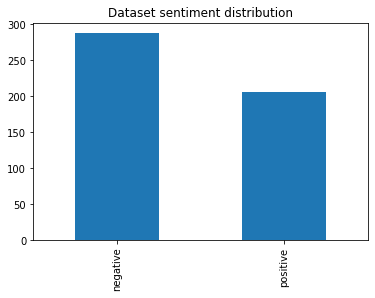

In [ ]:
# Some Tokens are None which we must drop first
predictions.dropna(how='any', inplace=True)
# Some sentiment are 'na' which we must drop first
predictions = predictions[predictions.sentiment!= 'na']
predictions.sentiment.value_counts().plot.bar(title='Dataset sentiment distribution')

## 4.3 Checkout sentiment distribution

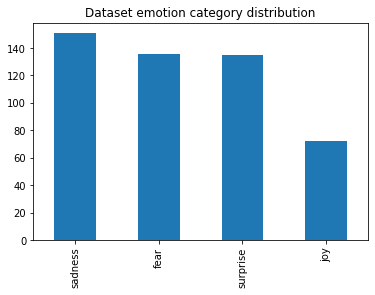

In [ ]:
predictions.category.value_counts().plot.bar(title='Dataset emotion category distribution')

# 5.Prepare data for T-SNE algorithm.
We create a Matrix with one row per Embedding vector for T-SNE algorithm

In [ ]:
import numpy as np

# We first create a column of type np array
predictions['np_array'] = predictions.sentence_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions.np_array])

## 5.1 Fit and transform T-SNE algorithm


In [ ]:

from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (494, 2)


### Set plotting styles

In [ ]:
# set some styles for for Plotting
import seaborn as sns
# Style Plots a bit
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1,rc={"lines.linewidth": 2.5})

%matplotlib inline
import matplotlib as plt
plt.rcParams['figure.figsize'] = (20, 14)


##5.2 Plot low dimensional T-SNE USE embeddings with hue for Sarcasm


Text(0.5, 1.0, 'T-SNE USE Embeddings, colored by Sarcasm label')

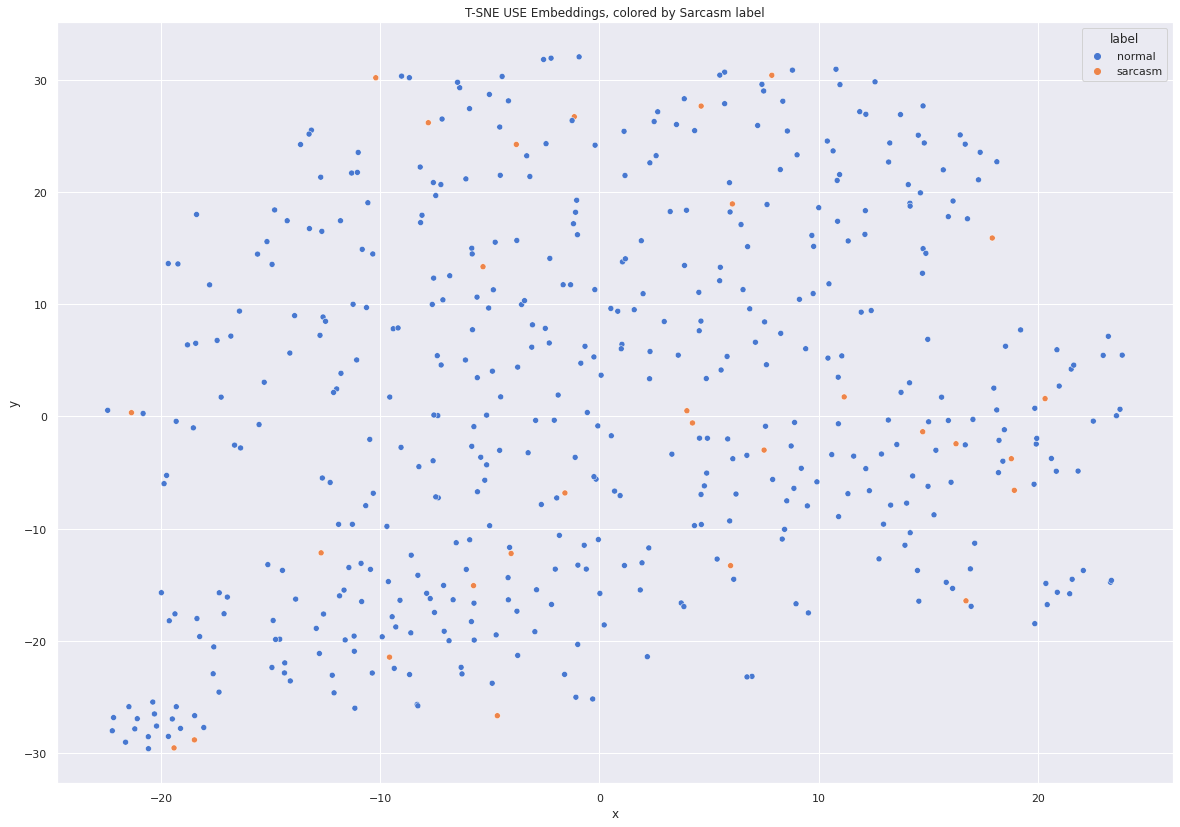

In [ ]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.label.replace({1:'sarcasm',0:'normal'}))
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE USE Embeddings, colored by Sarcasm label')


## 5.3 Plot low dimensional T-SNE USE embeddings with hue for Sentiment


Text(0.5, 1.0, 'T-SNE USE Embeddings, colored by Sentiment')

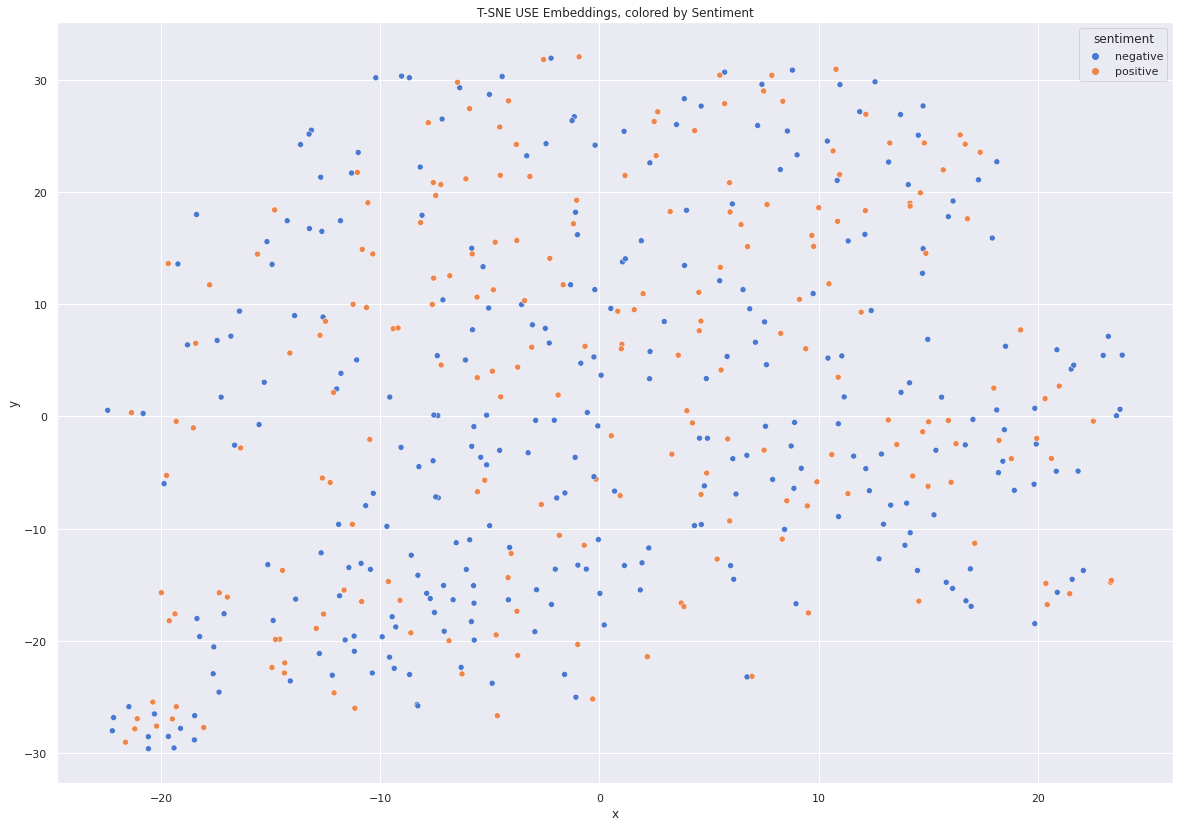

In [ ]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.sentiment)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE USE Embeddings, colored by Sentiment')


# 5.4 Plot low dimensional T-SNE USE embeddings with hue for Emotions


Text(0.5, 1.0, 'T-SNE use Embeddings, colored by Emotion')

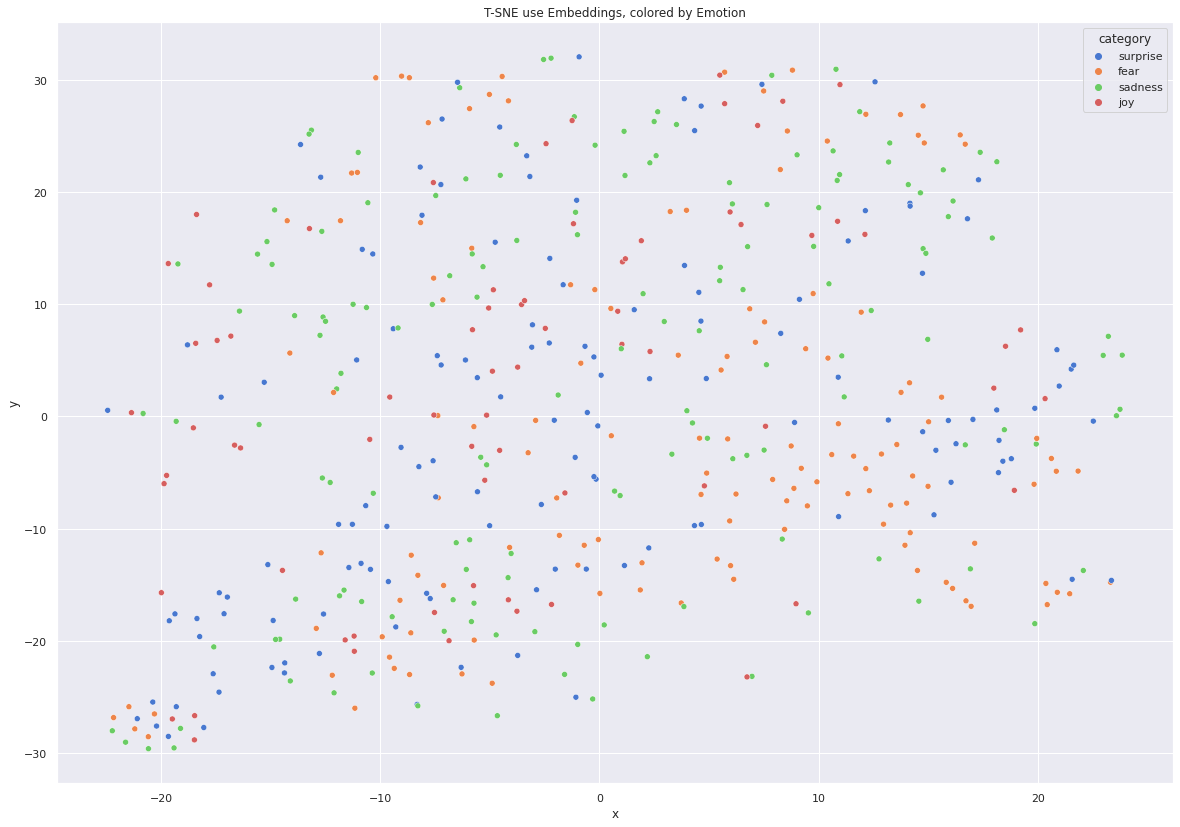

In [ ]:
tsne_df =  pd.DataFrame(low_dim_data, predictions.category)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE use Embeddings, colored by Emotion')


# 6.1 Plot low dimensional T-SNE USE embeddings with hue for POS     
Because we will have a list of pos labels for each sentence, we need to explode on the pos column and then do the data peperation for T-SNE again before we can visualize with hue for POS


In [ ]:
predictions_exploded_on_pos = predictions.explode('pos')
predictions_exploded_on_pos

,document_assembler@sentiment,text,sentiment,sentence,category,sentiment_confidence,category_confidence,checked,sentence_embeddings,pos,label,sentence_detector@sentiment,np_array
origin_index,,,,,,,,,,,,,
0,[NC and NH.],NC and NH.,negative,NC and NH.,surprise,0.522900,0.972704,"[NC, and, NH, .]","[-0.06570463627576828, -0.03522053360939026, -...",NNP,0,[NC and NH.],"[-0.06570463627576828, -0.03522053360939026, -..."
0,[NC and NH.],NC and NH.,negative,NC and NH.,surprise,0.522900,0.972704,"[NC, and, NH, .]","[-0.06570463627576828, -0.03522053360939026, -...",CC,0,[NC and NH.],"[-0.06570463627576828, -0.03522053360939026, -..."
0,[NC and NH.],NC and NH.,negative,NC and NH.,surprise,0.522900,0.972704,"[NC, and, NH, .]","[-0.06570463627576828, -0.03522053360939026, -...",NNP,0,[NC and NH.],"[-0.06570463627576828, -0.03522053360939026, -..."
0,[NC and NH.],NC and NH.,negative,NC and NH.,surprise,0.522900,0.972704,"[NC, and, NH, .]","[-0.06570463627576828, -0.03522053360939026, -...",.,0,[NC and NH.],"[-0.06570463627576828, -0.03522053360939026, -..."
1,[You do know west teams play against west team...,You do know west teams play against west teams...,negative,You do know west teams play against west teams...,fear,0.473300,0.999838,"[You, do, know, west, teams, play, against, we...","[-0.0254225991666317, 0.05448468029499054, -0....",PRP,0,[You do know west teams play against west team...,"[-0.0254225991666317, 0.05448468029499054, -0...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,[Hard drive requirements tend to include extra...,Hard drive requirements tend to include extra ...,positive,Hard drive requirements tend to include extra ...,surprise,0.539600,0.991925,"[Hard, drive, requirements, tend, to, include,...","[0.02939368598163128, -0.027575558051466942, -...",IN,0,[Hard drive requirements tend to include extra...,"[0.02939368598163128, -0.027575558051466942, -..."
499,[Hard drive requirements tend to include extra...,Hard drive requirements tend to include extra ...,positive,Hard drive requirements tend to include extra ...,surprise,0.539600,0.991925,"[Hard, drive, requirements, tend, to, include,...","[0.02939368598163128, -0.027575558051466942, -...",DT,0,[Hard drive requirements tend to include extra...,"[0.02939368598163128, -0.027575558051466942, -..."
499,[Hard drive requirements tend to include extra...,Hard drive requirements tend to include extra ...,positive,Hard drive requirements tend to include extra ...,surprise,0.539600,0.991925,"[Hard, drive, requirements, tend, to, include,...","[0.02939368598163128, -0.027575558051466942, -...",NN,0,[Hard drive requirements tend to include extra...,"[0.02939368598163128, -0.027575558051466942, -..."


## 6.2 Preprocess data for TSNE again

In [ ]:

# We first create a column of type np array
predictions_exploded_on_pos['np_array'] = predictions_exploded_on_pos.sentence_embeddings.apply(lambda x: np.array(x))
# Make a matrix from the vectors in the np_array column via list comprehension
mat = np.matrix([x for x in predictions_exploded_on_pos.np_array])


from sklearn.manifold import TSNE
model = TSNE(n_components=2) #n_components means the lower dimension
low_dim_data = model.fit_transform(mat)
print('Lower dim data has shape',low_dim_data.shape)

Lower dim data has shape (6407, 2)


# 6.3 Plot low dimensional T-SNE USE embeddings with hue for POS     


Text(0.5, 1.0, 'T-SNE USE Embeddings, colored by Part of Speech Tag')

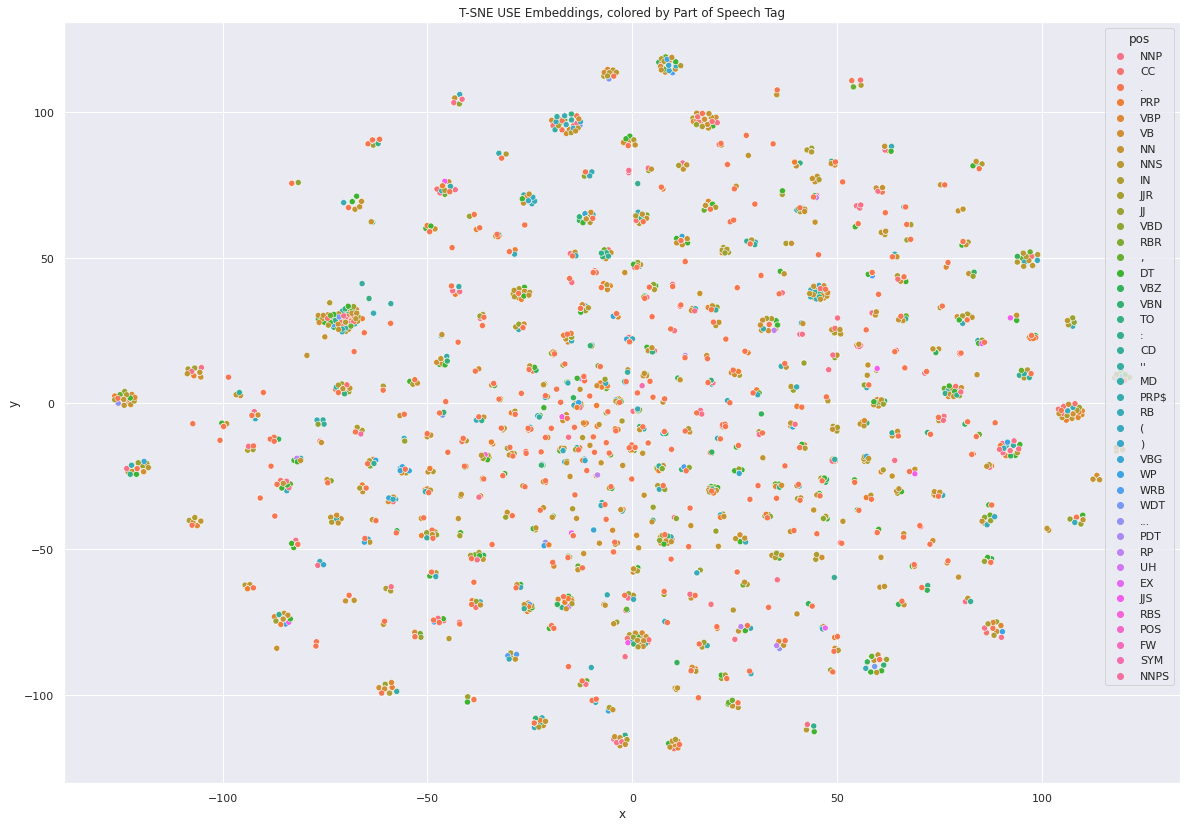

In [ ]:
tsne_df =  pd.DataFrame(low_dim_data, predictions_exploded_on_pos.pos)
tsne_df.columns = ['x','y']
ax = sns.scatterplot(data=tsne_df, x='x', y='y', hue=tsne_df.index)
ax.set_title('T-SNE USE Embeddings, colored by Part of Speech Tag')


# 7. NLU has many more embedding models!      
Make sure to try them all out!       
You can change 'use' in nlu.load('use') to bert, xlnet, albert or any other of the **100+ word embeddings** offerd by NLU

In [ ]:
nlu.print_all_model_kinds_for_action('embed')

For language <en> NLU provides the following Models : 
nlu.load('en.embed') returns Spark NLP model glove_100d
nlu.load('en.embed.glove') returns Spark NLP model glove_100d
nlu.load('en.embed.glove.100d') returns Spark NLP model glove_100d
nlu.load('en.embed.bert') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_uncased') returns Spark NLP model bert_base_uncased
nlu.load('en.embed.bert.base_cased') returns Spark NLP model bert_base_cased
nlu.load('en.embed.bert.large_uncased') returns Spark NLP model bert_large_uncased
nlu.load('en.embed.bert.large_cased') returns Spark NLP model bert_large_cased
nlu.load('en.embed.biobert') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_base_cased') returns Spark NLP model biobert_pubmed_base_cased
nlu.load('en.embed.biobert.pubmed_large_cased') returns Spark NLP model biobert_pubmed_large_cased
nlu.load('en.embed.biobert.pmc_base_cased') returns Spark NLP model biobert_pmc_base_cased
nlu.lo